In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

# Ignore SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

# Load the data
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

# Merge product and transaction data
data = pd.merge(transactions, products, on='product_id', how='left')


In [26]:
# Check if there are customers with less than two orders in the dataset
check = data.groupby('user_id').agg(
    {'order_number': 'max'}).reset_index()['order_number'].min()
if check > 2:
    print("All customers made more than two orders. All data can be used.")
else:
    print("There are customers with a total number of orders less than three. Data cleanup required.")
    

All customers made more than two orders. All data can be used.


In [2]:
# Sort the dataframe by 'order_number' in descending order
last_orders = transactions.sort_values('order_number', ascending=False)
# Select only the last orders for each user using the 'tail' function
last_orders = last_orders.groupby('user_id').tail(1)['order_id']

# Split the data into last orders dataset and training dataset
last_orders_data = data[data['order_id'].isin(last_orders)]
order_for_train = data[~(data['order_id'].isin(last_orders))]

Minimum reorder rate: 0.0
Maximum reorder rate: 50.26984126984127
Median reorder rate: 5.206896551724138
Mean reorder rate: 6.222023848556705
10th percentile of reorder rate: 1.9090909090909092
90th percentile of reorder rate: 11.833333333333334


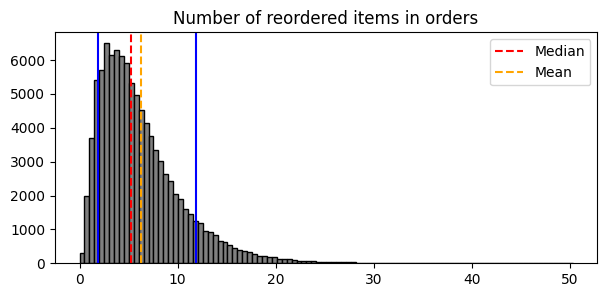

In [14]:
# Add a column with the total number of orders for each user
order_for_train['max_order'] = order_for_train.groupby('user_id')['order_number'].transform('max')

# Calculate the "reorder rate" metric, which represents the frequency of reordering by users
reoder_rate = order_for_train.groupby('user_id').agg(
    {'order_number': 'max', 'reordered': 'sum'}).reset_index()
reoder_rate['rate'] = reoder_rate['reordered'] / (reoder_rate['order_number'] - 1)

# Calculate various statistics of the reorder rate metric and display them on a histogram
median_reoder_rate = reoder_rate['rate'].median()
mean_reoder_rate = reoder_rate['rate'].mean()
quartiles = np.percentile(reoder_rate['rate'], [10, 90])
print("Minimum reorder rate:", reoder_rate['rate'].min())
print("Maximum reorder rate:", reoder_rate['rate'].max())
print("Median reorder rate:", median_reoder_rate)
print("Mean reorder rate:", mean_reoder_rate)
print("10th percentile of reorder rate:", quartiles[0])
print("90th percentile of reorder rate:", quartiles[1])

plt.figure(figsize=(7,3))
plt.hist(reoder_rate['rate'],
         bins=int(reoder_rate['rate'].max()*2),
         color='gray',
         edgecolor='black')
plt.axvline(median_reoder_rate, color='red', linestyle='--', label='Median')
plt.axvline(mean_reoder_rate, color='green',
            linestyle='--', label='Mean', c="orange")
for q in quartiles:
    plt.axvline(q, color='blue', linestyle='-')
plt.title('Number of reordered items in orders')
plt.legend()
plt.show()


Minimum products in one order: 1
Maximum products in one order: 145
Median products in one order: 8.0
Mean products in one order: 10.13026826197681
10th percentile of products in one order: 2.0
90th percentile of products in one order: 20.0


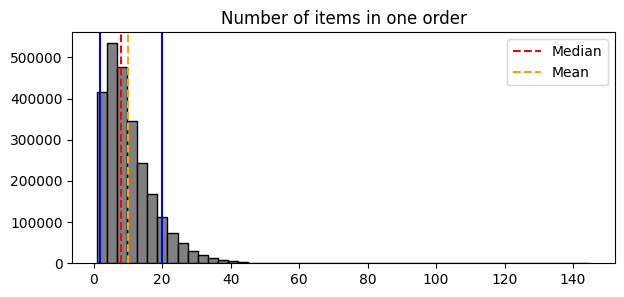

In [16]:
# Calculate and display data about the size of the shopping cart on a histogram
products_in_orders = order_for_train.groupby(
    'order_id').agg({'product_id': 'count'}).reset_index()

median_products = products_in_orders['product_id'].median()
mean_products = products_in_orders['product_id'].mean()
quartiles = np.percentile(products_in_orders['product_id'], [10, 90])
print("Minimum products in one order:", products_in_orders['product_id'].min())
print("Maximum products in one order:", products_in_orders['product_id'].max())
print("Median products in one order:", median_products)
print("Mean products in one order:", mean_products)
print("10th percentile of products in one order:", quartiles[0])
print("90th percentile of products in one order:", quartiles[1])

plt.figure(figsize=(7,3))
plt.hist(products_in_orders['product_id'],
         bins=int(np.ceil(products_in_orders['product_id'].max()/3)),
         color='gray',
         edgecolor='black')
plt.axvline(median_products, color='red', linestyle='--', label='Median')
plt.axvline(mean_products, color='green',
            linestyle='--', label='Mean', c="orange")
for q in quartiles:
    plt.axvline(q, color='blue', linestyle='-')
plt.title('Number of items in one order')
plt.legend()
plt.show()


In [6]:
# From the histograms, we can observe that the median order size is around 8 items per order,
# and the median number of reordered items per order is approximately 5.
# This suggests that the "median" customer primarily orders items they have previously ordered.


In [29]:
# Добавим столбец с "весом заказа", значение которого тем выше, чем номер заказа ближе к последнему.
# Add a column with the "order weight", the value of which is higher, the closer the order number is to the last one.
order_for_train.loc[:, 'weight_order'] = order_for_train['order_number'] / \
    order_for_train['max_order']


In [8]:
# Calculate the weight of product categories based on the frequency of orders by users and the "order weight"
department_weight = order_for_train.groupby(
    ['order_id', 'user_id', 'department_id', 'weight_order']).agg({'department': 'count'}).reset_index()
department_weight['weight_department'] = department_weight['department'] * \
    department_weight['weight_order']
department_weight['weight_department'] = department_weight.groupby(
    ['order_id', 'user_id', 'department_id'])['weight_department'].cumsum()
department_weight = department_weight[[
    'order_id', 'user_id', 'department_id', 'weight_department']]

order_for_train = pd.merge(order_for_train, department_weight, on=[
                           'order_id', 'user_id', 'department_id'], how='left')


In [9]:
# Calculate the weight of product subcategories based on the frequency of orders by users and the "order weight"
aisle_weight = order_for_train.groupby(
    ['order_id', 'user_id', 'aisle_id', 'weight_order']).agg({'aisle': 'count'}).reset_index()
aisle_weight['weight_aisle'] = aisle_weight['aisle'] * \
    aisle_weight['weight_order']
aisle_weight['weight_aisle'] = aisle_weight.groupby(
    ['order_id', 'user_id', 'aisle_id'])['weight_aisle'].cumsum()
aisle_weight = aisle_weight[['order_id',
                             'user_id', 'aisle_id', 'weight_aisle']]

order_for_train = pd.merge(order_for_train, aisle_weight, on=[
                           'order_id', 'user_id', 'aisle_id'], how='left')


In [10]:
# Accumulate the "order weight" to obtain weights for each items.
# The logic is to assign higher weights to items that were ordered periodically and are more "fresh".
order_for_train['weight_order'] = order_for_train.groupby(
    ['user_id', 'product_id'])['weight_order'].cumsum()

# Keep only two necessary columns in the last orders dataset
last_orders_data = last_orders_data[['user_id', 'product_id']]


In [11]:
def average_precision_at_k(cart_ist_user, cart_soll_user, k):
     # Limit the predictions to top K items
    cart_soll_user = cart_soll_user['product_id'][:k]
    
    actual = cart_ist_user['product_id'].values
    
    # Create a binary label vector for the predicted items
    y_pred = np.isin(cart_soll_user, actual).astype(int)
    
    # Calculate precision at K
    precision = np.cumsum(y_pred) / np.arange(1, k+1)
    
    # Calculate average precision at K
    average_precision = np.sum(precision * y_pred) / min(len(actual), k)
    
    return average_precision


def MAP_at_n(cart_ist, cart_soll, n=10):
    grouped_cart_ist = cart_ist.groupby('user_id')
    grouped_cart_soll = cart_soll.groupby('user_id')
    users = grouped_cart_soll.groups.keys()
    
    map_at_n = 0

    for user_id  in users:
        cart_ist_user = grouped_cart_ist.get_group(user_id)
        cart_soll_user = grouped_cart_soll.get_group(user_id)
        map_at_n = map_at_n + \
            average_precision_at_k(cart_ist_user, cart_soll_user, k=n)

    return map_at_n/len(users)


In [12]:
# Find the top 10 most popular products for training set
best_10 = order_for_train.groupby('product_id').agg({'user_id' : 'count'}).reset_index().sort_values('user_id', ascending=False)[:10]

In [13]:
# First test
# Use the product weights (order, department, aisle) as the ranking for each user.
order_for_train_1 = order_for_train.groupby(['user_id', 'product_id']).agg(
    {'weight_order': 'max', 'weight_department': 'max', 'weight_aisle': 'max'}).reset_index()

order_for_train_1['new_weight'] = order_for_train_1['weight_order'] * \
    order_for_train_1['weight_department'] * order_for_train_1['weight_aisle']
    
order_for_train_1 = order_for_train_1.sort_values(
    by=['user_id', 'new_weight'], ascending=[True, False]).reset_index()

order_for_train_1 = order_for_train_1[['user_id', 'product_id']]

# If users have less than 10 products in the prediction, then we add some from 10 most popular products
df_grouped = order_for_train_1.groupby('user_id')
users = df_grouped.groups.keys()
for user_id  in users:
        df_user = df_grouped.get_group(user_id)
        if len(df_user['product_id']) < 10:
            user_best_10 = best_10[~(best_10['product_id'].isin(df_user['product_id']))][:10-len(df_user['product_id'])]
            user_best_10['user_id'] = user_id
            order_for_train_1 = pd.concat([order_for_train_1, user_best_10])

map_1 = MAP_at_n(last_orders_data, order_for_train_1)
print(round(map_1, 5))
# Kaggle results: Private Score 0.24848 / Public Score 0.24842
# Goal: 0.20954


0.16191


In [14]:
# Second test
# Use only the order weight as the ranking
order_for_train_2 = order_for_train.groupby(['user_id', 'product_id']).agg({
    'weight_order': 'max'}).reset_index()

order_for_train_2 = order_for_train_2.sort_values(
    by=['user_id', 'weight_order'], ascending=[True, False]).reset_index()

order_for_train_2 = order_for_train_2[['user_id', 'product_id']]

# If users have less than 10 products in the prediction, then we add some from 10 most popular products
df_grouped = order_for_train_2.groupby('user_id')
users = df_grouped.groups.keys()
for user_id  in users:
        df_user = df_grouped.get_group(user_id)
        if len(df_user['product_id']) < 10:
            user_best_10 = best_10[~(best_10['product_id'].isin(df_user['product_id']))][:10-len(df_user['product_id'])]
            user_best_10['user_id'] = user_id
            order_for_train_2 = pd.concat([order_for_train_2, user_best_10])

map_2 = MAP_at_n(last_orders_data, order_for_train_2)
print(round(map_2, 5))
# Kaggle results: Private Score 0.30824 / Public Score 0.3098
# Goal: 0.20954


0.22222


In [15]:
# Third test
# For each user, use the product weights divided by the median add_to_cart_order as the ranking
order_for_train_3 = order_for_train.groupby(['user_id', 'product_id']).agg(
    {'weight_order': 'max', 'add_to_cart_order': np.median}).reset_index()

order_for_train_3['new_weight'] = order_for_train_3['weight_order'] / \
    order_for_train_3['add_to_cart_order']
    
order_for_train_3 = order_for_train_3.sort_values(
    by=['user_id', 'new_weight'], ascending=[True, False]).reset_index()

order_for_train_3 = order_for_train_3[['user_id', 'product_id']]

# If users have less than 10 products in the prediction, then we add some from 10 most popular products
df_grouped = order_for_train_3.groupby('user_id')
users = df_grouped.groups.keys()
for user_id  in users:
        df_user = df_grouped.get_group(user_id)
        if len(df_user['product_id']) < 10:
            user_best_10 = best_10[~(best_10['product_id'].isin(df_user['product_id']))][:10-len(df_user['product_id'])]
            user_best_10['user_id'] = user_id
            order_for_train_3 = pd.concat([order_for_train_3, user_best_10])
            
map_3 = MAP_at_n(last_orders_data, order_for_train_3)
print(round(map_3, 5))
# Kaggle results: Private Score 0.30834 / Public Score 0.30981
# Goal: 0.20954


0.2263


In [16]:
# Fourth test
# For each user, use the product weights divided by the mean add_to_cart_order as the ranking

order_for_train_4 = order_for_train.groupby(['user_id', 'product_id']).agg(
    {'weight_order': 'max', 'add_to_cart_order': 'mean'}).reset_index()

order_for_train_4['new_weight'] = order_for_train_4['weight_order'] / \
    order_for_train_4['add_to_cart_order']
    
order_for_train_4 = order_for_train_4.sort_values(
    by=['user_id', 'new_weight'], ascending=[True, False]).reset_index()

order_for_train_4 = order_for_train_4[['user_id', 'product_id']]

# If users have less than 10 products in the prediction, then we add some from 10 most popular products
df_grouped = order_for_train_4.groupby('user_id')
users = df_grouped.groups.keys()
for user_id  in users:
        df_user = df_grouped.get_group(user_id)
        if len(df_user['product_id']) < 10:
            user_best_10 = best_10[~(best_10['product_id'].isin(df_user['product_id']))][:10-len(df_user['product_id'])]
            user_best_10['user_id'] = user_id
            order_for_train_4 = pd.concat([order_for_train_4, user_best_10])
            
map_4 = MAP_at_n(last_orders_data, order_for_train_4)
print(round(map_4, 5))
# Kaggle results: Private Score 0.26942 / Public Score 0.2704
# Goal: 0.20954

0.2222


## kaggle

In [17]:
# order_for_train = pd.read_csv('transactions.csv')

# order_for_train['max_order'] = order_for_train.groupby('user_id')['order_number'].transform('max')

# order_for_train['weight_order'] = order_for_train['order_number'] / \
#     order_for_train['max_order']

# order_for_train['weight_order'] = order_for_train.groupby(
#     ['user_id', 'product_id'])['weight_order'].cumsum()

# best_10 = order_for_train.groupby('product_id').agg({'user_id' : 'count'}).reset_index().sort_values('user_id', ascending=False)[:10]

# order_for_train = order_for_train.groupby(['user_id', 'product_id']).agg(
#     {'weight_order': 'max', 'add_to_cart_order': np.median}).reset_index()

# order_for_train['new_weight'] = order_for_train['weight_order'] / \
#     order_for_train['add_to_cart_order']
    
# df = order_for_train.sort_values(
#     by=['user_id', 'new_weight'], ascending=[True, False])   


# df_top = df.groupby('user_id')
# users = df_top.groups.keys()
# for user_id  in users:
#         df_user = df_top.get_group(user_id)
#         if len(df_user['product_id']) < 10:
#             user_best_10 = best_10[~(best_10['product_id'].isin(df_user['product_id']))][:10-len(df_user['product_id'])]
#             user_best_10['user_id'] = user_id
#             df = pd.concat([df, user_best_10])

# df_grouped = df.groupby('user_id').apply(lambda x: ' '.join(x.sort_values(
#     'weight_order', ascending=False)['product_id'].head(10).astype(str)))
# df_grouped = df_grouped.reset_index()
# df_grouped.columns = ['user_id', 'product_id']

# df_grouped.to_csv('kaggle_submission_004.csv', index=False)